<h1><span style='font-family: "Trebuchet MS", Helvetica, sans-serif;'>Neural Networks - Module Project-II | Signal Strength GUI</span></h1>

<para><span style='font-family: "Trebuchet MS", Helvetica, sans-serif;'>Imports</span></para>

In [1]:
import tensorflow
import pandas as pd
import numpy as np
import tkinter as tk

from pathlib import Path
from tkinter.filedialog import askopenfilename
import warnings
warnings.filterwarnings("ignore")

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.callbacks import LambdaCallback, EarlyStopping

<para><span style='font-family: "Trebuchet MS", Helvetica, sans-serif;'>Utility functions to build and train classifiers and load data</span></para>

In [2]:
seed = 77

def plot_learning_curve(hist, metric='mae'):
    sns.set()
    plt.figure(figsize=(5, 4))
    train = hist.history[metric]
    val = hist.history[f'val_{metric}']
    epochs_run = range(1,len(train) + 1)
    sns.lineplot(epochs_run, train, marker = 'o', color = 'coral', label = 'Training')
    sns.lineplot(epochs_run, val,  marker = '>', color = 'green', label = 'Validation')
    plt.title(f"{metric.capitalize()} vs. Epochs", fontsize = 20)
    plt.legend()
    plt.show()

def categorise_signal(row):
    """Feature Engineering to categorise signal strength for classifier model"""
    if row >= 7:
        return 3
    elif row <=4:
        return 1
    else:
        return 2

def get_regressor(input_dim=7):
    model = Sequential([
        Dense(25, input_dim=7, kernel_initializer='he_normal', activation='relu'),
        Dropout(0.21),
        Dense(25, activation='relu'),
        Dropout(0.21),
        Dense(1, activation='linear')
    ])
    return model

def get_classifier(input_dim=7):
    """Defines the architecture of the Signal Strength classifier"""
    model = Sequential([
        Dense(25, input_dim=input_dim, kernel_initializer='he_normal', activation='relu'),
        Dropout(0.21),
        Dense(25, activation='relu'),
        Dropout(0.21),
        Dense(4, activation='softmax')
        ])
    return model

def import_csv_data():
    """Code to import csv data"""
    global v, csv_check, df
    csv_file_path = askopenfilename()
    csv_file_path = Path(csv_file_path)
    print(csv_file_path)
    v.set(csv_file_path)
    try:
        csv_check.set("")
        df = pd.read_csv(csv_file_path)
        print(df.shape)
        csv_check.set("Done")
    except Exception as e:
        print(e)
        csv_check.set("Not a CSV")

def check_target():
    """To check if column is present or not"""
    global target, target_found
    if target.get() in df.columns:
        target_found.set("Found")
    else:
        target_found.set("Not Found")

def regressor_train():
    """Train Regressor model"""
    global model1, trained
    df1 = df.copy()
    
    selected_columns = ['Parameter 2', 'Parameter 3', 'Parameter 5',
                        'Parameter 7', 'Parameter 8', 'Parameter 10',
                        'Parameter 11', 'Signal_Strength']
    selected_df = df[selected_columns].copy()

    X = selected_df.drop('Signal_Strength', axis=1)
    Y = selected_df['Signal_Strength']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
    X_train.shape, X_test.shape

    # get model
    model1 = get_regressor()
    # define callbaks
    # To simplify the log
    simple_log = LambdaCallback(
        on_epoch_end = lambda e, l: print(f" ~| Epoch: {e+1} | Validation Mae: {l['val_mae']:.5f}", end =" >|> \n" ))

    early_stop = EarlyStopping(monitor='val_mae',
                               min_delta=0,
                               patience=10,
                               verbose=1, 
                               restore_best_weights=True)
    # complie
    model1.compile(loss='mae', optimizer='adam', metrics=['mae', 'mse'])
    # train
    try:
        trained.set("")
        epochs = 300
        batch_size = 64
        h = model1.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_split=0.2,
                       callbacks = [early_stop, simple_log],
                       verbose = False)
        trained.set("Network trained")
    except Exception as e:
        print(e)
        trained.set("Error while Training the network")

def classifier_train():
    """Train classifier model"""
    global model2, model_trained_flag
    df2 = df.copy()
    selected_columns = ['Parameter 2', 'Parameter 3', 'Parameter 5',
                        'Parameter 7', 'Parameter 8', 'Parameter 10',
                        'Parameter 11', 'Signal_Strength']
    selected_df = df[selected_columns].copy()

    merged_df = selected_df.copy(True)
    # merge the output classes given that we have very huge imbalance in the classes
    # binning the output classes
    merged_df['Signal_Strength'] = merged_df['Signal_Strength'].apply(categorise_signal)
    # converting Signal_stregth to categorical series as we want to build a classifier instead of regressor
    categorical_labels = to_categorical(merged_df['Signal_Strength'], num_classes=None)
    X = merged_df.drop('Signal_Strength', axis=1)
    Y = categorical_labels
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
    X_train.shape, X_test.shape
    model2 = get_classifier()
    # define callbacks
    simple_log = LambdaCallback(
        on_epoch_end = lambda e, l: print(f" ~| Epoch: {e+1} | Validation Loss: {l['val_loss']:.5f}", end =" >|> \n" ))

    early_stop = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=10,
                               verbose=1, 
                               restore_best_weights=True)
    # compile
    model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    try:
        model_trained_flag.set("")
        epochs = 300
        batch_size = 64
        h = model2.fit(X_train, y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_split=0.2, 
                      callbacks = [early_stop, simple_log],
                      verbose = False)
        model_trained_flag.set("Network trained")
    except Exception as e:
        print(e)
        model_trained_flag.set("Error while Training the network")

def save_regressor_model():
    """Save Regressor model"""
    global saved
    try:
        saved.set("")
        model1.save("Signal_Strength_Regressor_GUI.h5")
        saved.set("Saved to the Disk")
    except:
        saved.set("Not able to save due to the error")

def save_classifier_model():
    """Saving Classifier model"""
    global model_saved_flag
    try:
        model_saved_flag.set("")
        model2.save("Signal_Classification_model_GUI.h5")
        model_saved_flag.set("Saved to the Disk")
    except:
        model_saved_flag.set("Not able to save due to the error")

<para><span style='font-family: "Trebuchet MS", Helvetica, sans-serif;'>GUI with TKinter</span></para>

In [3]:
# Select dataset
root = tk.Tk()
root.title('Signal Strength Prediction')
tk.Label(root, text='Step 1: File Name').grid(row=5, column=0)
v = tk.StringVar()
csv_check = tk.StringVar()
entry = tk.Entry(root, textvariable=v).grid(row=5, column=1)
tk.Button(root, text='Import Data',command=import_csv_data).grid(row=5, column=2)
entry2 = tk.Entry(root, textvariable=csv_check).grid(row=5, column=3)


# Select target
tk.Label(root, text='Step 2: Target Column').grid(row=7, column=0)
target = tk.StringVar()
target_found = tk.StringVar()
userentry = tk.Entry(root, textvariable=target).grid(row=7, column=1)
tk.Button(root, text='Import Target',command=check_target).grid(row=7, column=2)
found_or_not = tk.Entry(root, textvariable=target_found).grid(row=7, column=3)

# Regressor
tk.Label(root, text='Step 3: Neural Network Regressor').grid(row=8, column=0)
tk.Label(root, text='Regression').grid(row=9, column=0)
tk.Label(root, text='Pickle').grid(row=10, column=0)
trained = tk.StringVar()
saved = tk.StringVar()
tk.Button(root, text='Train',command=regressor_train).grid(row=9, column=1)
tr_entry = tk.Entry(root, textvariable=trained).grid(row=9, column=2)
tk.Button(root, text='Run',command=save_regressor_model).grid(row=10, column=1)
savedentry = tk.Entry(root, textvariable=saved).grid(row=10, column=2)

# Classifier
tk.Label(root, text='Step 3: Neural Network Classifier').grid(row=11, column=0)
tk.Label(root, text='Classification').grid(row=12, column=0)
tk.Label(root, text='Pickle').grid(row=13, column=0)
model_trained_flag = tk.StringVar()
model_saved_flag = tk.StringVar()
tk.Button(root, text='Train',command=classifier_train).grid(row=12, column=1)
tr_entry_c = tk.Entry(root, textvariable=model_trained_flag).grid(row=12, column=2)
tk.Button(root, text='Run',command=save_classifier_model).grid(row=13, column=1)
saved_c = tk.Entry(root, textvariable=model_saved_flag).grid(row=13, column=2)
root.mainloop()

C:\Users\surya\dev\nn\Part- 1,2&3 - Signal.csv
(1599, 12)
 ~| Epoch: 1 | Validation Mae: 20.44582 >|> 
 ~| Epoch: 2 | Validation Mae: 0.83914 >|> 
 ~| Epoch: 3 | Validation Mae: 6.60029 >|> 
 ~| Epoch: 4 | Validation Mae: 0.58067 >|> 
 ~| Epoch: 5 | Validation Mae: 1.37494 >|> 
 ~| Epoch: 6 | Validation Mae: 1.42147 >|> 
 ~| Epoch: 7 | Validation Mae: 0.66106 >|> 
 ~| Epoch: 8 | Validation Mae: 1.41546 >|> 
 ~| Epoch: 9 | Validation Mae: 0.94542 >|> 
 ~| Epoch: 10 | Validation Mae: 0.99450 >|> 
 ~| Epoch: 11 | Validation Mae: 0.67414 >|> 
 ~| Epoch: 12 | Validation Mae: 0.70980 >|> 
 ~| Epoch: 13 | Validation Mae: 0.88146 >|> 
Restoring model weights from the end of the best epoch.
 ~| Epoch: 14 | Validation Mae: 0.97233 >|> 
Epoch 00014: early stopping
 ~| Epoch: 1 | Validation Loss: 14.31264 >|> 
 ~| Epoch: 2 | Validation Loss: 0.91865 >|> 
 ~| Epoch: 3 | Validation Loss: 1.94970 >|> 
 ~| Epoch: 4 | Validation Loss: 2.59360 >|> 
 ~| Epoch: 5 | Validation Loss: 2.72329 >|> 
 ~| Epoch:

In [ ]:
# Successfuly trained and saved the models using GUI

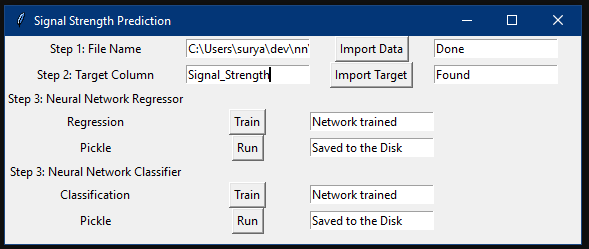